In [34]:
import platform
import torch

print("Python version")
!python --version

print("\nOS information")
print(platform.platform())

print("\nIs GPU available?")
print(torch.cuda.is_available())

# print("\nCPU information")
# !cat /proc/cpuinfo

# print("\nMemory information")
# !cat /proc/meminfo

print("\nGPU information")
!nvidia-smi

Python version
Python 3.11.10

OS information
Linux-5.4.0-193-generic-x86_64-with-glibc2.31

Is GPU available?
True

GPU information
Sat Oct 26 10:06:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:01:00.0 Off |                  Off |
| 30%   32C    P8              16W / 230W |   9792MiB / 24564MiB |      0%      Default |
|                        

### 훈련이미지셋 배경제거 (u2net_human_seg) 
https://github.com/xuebinqin/U-2-Net

U2net기반 모델의 사람 검출에 특화된 세그멘테이션 Fine-Tuning 모델을 이용하여 사람과 배경을 마스킹하고 불필요한 부분을 제거

*주의 : 오랜 시간이 걸리므로 CPU자원을 최대한으로 끌어서 병렬처리를 진행

In [ ]:
import os
import io
import multiprocessing
from rembg import remove, new_session
from PIL import Image
from tqdm import tqdm 

# 배경 제거 함수
def remove_background(args):
    image_path, output_dir = args  # unpacking 인자
    # 1. 이미지 가져오기
    with open(image_path, "rb") as img_file:
        input_img = img_file.read()
    
    # 2. 배경 제거
    model_name = "u2net_human_seg"
    session = new_session(model_name)

    out = remove(input_img, session=session)

    # 3. RGBA를 흰색 배경으로 변경
    out_img = Image.open(io.BytesIO(out))  # bytes 데이터를 PIL 이미지로 변환
    
    if out_img.mode == 'RGBA':
        # 흰색 배경을 가진 새로운 이미지 생성
        background = Image.new("RGB", out_img.size, (255, 255, 255))
        # 투명한 부분을 흰색으로 채움
        background.paste(out_img, (0, 0), out_img)
        out_img = background  # 흰색 배경을 가진 이미지로 대체
    
    # 4. 저장할 경로 지정
    img_name = os.path.basename(image_path)
    output_path = os.path.join(output_dir, img_name)

    # 5. 처리된 이미지 저장
    out_img.save(output_path, format='JPEG')  # JPEG로 저장

# 병렬 처리 함수
def process_images_in_parallel(image_paths, output_dir, num_workers=4):
    # 출력 디렉토리가 없다면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 멀티프로세싱 풀 생성
    pool = multiprocessing.Pool(num_workers)
    
    # tqdm을 사용하여 진행 상황 표시
    # 각 인자를 튜플로 전달
    for _ in tqdm(pool.imap(remove_background, [(image_path, output_dir) for image_path in image_paths]), total=len(image_paths), leave=True, ncols=100, desc='Processing images'):
        pass
    
    # 풀 종료
    pool.close()
    pool.join()

if __name__ == "__main__":
    # 이미지 파일이 들어 있는 디렉토리와 출력 디렉토리 설정
    input_dir = './data/training_image'  # 처리할 이미지가 있는 디렉토리
    output_dir = './data/training_image_rembg'   # 처리된 이미지 저장할 디렉토리
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 병렬로 이미지 처리 (CPU 코어 수에 따라 조정 가능)
    process_images_in_parallel(image_paths, output_dir, num_workers=50)


  0%|          | 0/4070 [00:00<?, ?it/s]

### 처리 이미지 정합성 확인

훈련데이터 갯수와 처리된 이미지의 수가 맞는지 확인하고, 도중에 중단되거나 오류가 있는 파일이 없는지 확인

In [7]:
import os
import sys

def get_file_list(path):
    file_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            file_list.append(file)
    return file_list

training_image_list = get_file_list('data/training_image')
print(len(training_image_list))
rembg_image_list = get_file_list('data/training_image_rembg')
print(len(training_image_list))

4070
4070


In [3]:
import os
from PIL import Image
from tqdm import tqdm

def find_corrupted_images(input_dir):
    corrupted_images = []
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    for image_path in tqdm(image_paths, ncols=100, leave=True):
        try:
            # 이미지 열기 (손상된 파일일 경우 예외 발생)
            with Image.open(image_path) as img:
                img.verify()  # 이미지 파일 검증
        except Exception as e:
            # 손상된 이미지 목록에 추가
            image_name  = os.path.basename(image_path)
            corrupted_images.append((image_name))
    
    return corrupted_images

if __name__ == "__main__":
    input_dir = './data/training_image_rembg'  # 손상된 파일을 확인할 디렉토리
    corrupted_images = find_corrupted_images(input_dir)
    
    if corrupted_images:
        print("손상된 이미지 파일:")
        for img_path in corrupted_images:
            print(f"{img_path}")
    else:
        print("손상된 이미지 파일이 없습니다.")

  0%|                                                                      | 0/4070 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████| 4070/4070 [00:00<00:00, 22702.19it/s]

손상된 이미지 파일이 없습니다.


### 처리중 손상된 이미지 재처리

In [9]:

input_dir = './data/training_image'  # 처리할 원본 이미지가 있는 디렉토리
output_dir = './data/training_image_rembg'   # 처리된 이미지 저장할 디렉토리

# output_dir에서 손상된 파일 리스트 찾기
corrupted_images = find_corrupted_images(output_dir)
print(f"손상된 파일 수: {len(corrupted_images)}")
# 손상된 파일 리스트를 기준으로 input_dir의 파일 경로 리스트 만들기
valid_image_paths = [os.path.join(input_dir, fname) for fname in corrupted_images if os.path.exists(os.path.join(input_dir, fname))]
# # 손상된 파일만 다시 처리
if valid_image_paths:
    process_images_in_parallel(valid_image_paths, output_dir, num_workers=4)



100%|████████████████████████████████████████████████████████| 4070/4070 [00:00<00:00, 22171.53it/s]

손상된 파일 수: 0


In [4]:
corrupted_images = find_corrupted_images(output_dir)
print(f"손상된 파일 수: {len(corrupted_images)}")


손상된 파일 수: 0


### 배경 제거 결과 후처리
배경을 제거하면서 잘못된 검출로 패션 데이터도 지워버릴 수 있기때문에 검증이 필요하다.

배경을 제거하고 흰색을 마스킹했기때문에 이미지에서 흰색 픽셀의 비율을 검출해 과다하게 많은 배경이 검출되는지 확인해본다. 

이상치의 기준이 되는 임계값을 찾기 위해 이미지의 흰색 픽셀 비율을 데이터프레임화 하고 Boxplot으로 살펴보았다.

Calculating white pixel percentage: 100%|███████████████████████| 4070/4070 [00:40<00:00, 99.83it/s]


,image_path,white_pixel_ratio
0,./data/training_image_rembg/W_01752_00_metrose...,0.775500
1,./data/training_image_rembg/W_46417_70_militar...,0.758449
2,./data/training_image_rembg/W_01509_00_metrose...,0.777762
3,./data/training_image_rembg/W_18951_50_feminin...,0.576494
4,./data/training_image_rembg/W_29485_10_sportiv...,0.622438
...,...,...
4065,./data/training_image_rembg/W_03060_50_feminin...,0.695795
4066,./data/training_image_rembg/W_00032_10_sportiv...,0.803211
4067,./data/training_image_rembg/W_02918_10_sportiv...,0.785070
4068,./data/training_image_rembg/W_08957_19_normcor...,0.868775


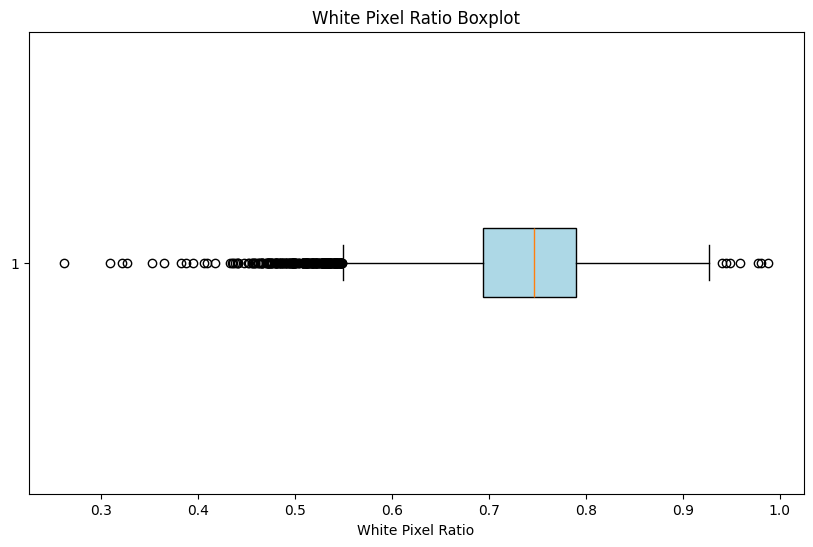

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import multiprocessing

def calculate_white_pixel_percentage_and_path(image_path):
    """
    단일 이미지에서 하얀색 픽셀이 차지하는 비율을 계산하는 함수.
    
    Args:
        image_path (str): 이미지 파일 경로
        
    Returns:
        tuple: 이미지 경로와 하얀색 픽셀 비율
    """
    # 이미지 열기 및 RGB로 변환
    image = Image.open(image_path).convert('RGB')
    
    # 이미지를 NumPy 배열로 변환
    image_np = np.array(image)
    
    # 흰색 픽셀 (255, 255, 255) 탐지
    white_pixels = np.all(image_np == [255, 255, 255], axis=-1)
    
    # 흰색 픽셀 비율 계산
    white_ratio = np.mean(white_pixels)
    
    return (image_path, white_ratio)  # 경로와 비율 둘 다 반환

def process_image(image_path):
    """
    multiprocessing에서 사용될 개별 이미지 처리 함수.
    """
    return calculate_white_pixel_percentage_and_path(image_path)

def create_white_pixel_dataframe_parallel(image_paths, num_workers=4):
    """
    병렬 처리를 통해 이미지 경로 리스트를 받아 흰색 픽셀 비율을 계산하고 데이터프레임 생성.
    
    Args:
        image_paths (list): 이미지 파일 경로 리스트
        num_workers (int): 병렬 처리에 사용할 워커 수
        
    Returns:
        DataFrame: 이미지 경로와 흰색 픽셀 비율을 포함한 데이터프레임
    """
    with multiprocessing.Pool(num_workers) as pool:
        # 병렬 처리 진행 상황을 tqdm으로 표시
        results = list(tqdm(pool.imap(process_image, image_paths), 
                            total=len(image_paths), desc="Calculating white pixel percentage", ncols=100, leave=True))
    
    # 결과를 바탕으로 데이터프레임 생성
    df = pd.DataFrame(results, columns=["image_path", "white_pixel_ratio"])  # 2개의 열로 설정
    
    return df

def plot_white_pixel_boxplot(df, output_path=None):
    """
    흰색 픽셀 비율의 boxplot을 그리는 함수. 주피터 노트북에 표시하거나 파일로 저장.
    
    Args:
        df (DataFrame): 흰색 픽셀 비율을 포함한 데이터프레임
        output_path (str): 저장할 파일 경로 (지정하지 않으면 노트북에 표시)
    """
    plt.figure(figsize=(10, 6))
    plt.boxplot(df['white_pixel_ratio'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title('White Pixel Ratio Boxplot')
    plt.xlabel('White Pixel Ratio')
    
    if output_path:
        # 이미지 파일로 저장
        plt.savefig(output_path)
        plt.close()
    else:
        # 주피터 노트북에 표시
        plt.show()

if __name__ == "__main__":
    # 배경 제거된 이미지가 저장된 디렉토리
    input_dir = './data/training_image_rembg'

    # 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 병렬로 흰색 픽셀 비율 계산 후 데이터프레임 생성
    df = create_white_pixel_dataframe_parallel(image_paths, num_workers=50)
    
    # 데이터프레임 저장 (필요한 경우)
    display(df)
    
    # boxplot 그리기
    plot_white_pixel_boxplot(df)

IQR Range가 0.7~8 에 걸쳐있는 것으로 보아 많은 이미지가 사람이 작게 표현되어서 흰색비율이 높게 나오는 것 같다. 

일단, 이상치로 보이는 데이터를 거르기 위해 범위를 벗어난 90% 이상이 흰색 픽셀인 그림을 필터링해보았다.

In [3]:
import os
import numpy as np
from PIL import Image
import multiprocessing
from tqdm import tqdm

def is_anomalous(image_path, threshold=0.9):
    """
    배경 제거된 이미지에서 흰색 픽셀이 차지하는 비율이 특정 임계값을 넘으면 True를 반환.
    """
    image = Image.open(image_path).convert('RGB')  # 이미지 열기
    image_np = np.array(image)  # 이미지를 NumPy 배열로 변환

    # 흰색 픽셀 (255, 255, 255) 탐지
    white_pixels = np.all(image_np == [255, 255, 255], axis=-1)
    
    # 흰색 픽셀 비율 계산
    white_ratio = np.mean(white_pixels)
    
    return image_path if white_ratio > threshold else None  # 임계값 초과 시 이상치로 판단

def process_image(image_path_threshold_tuple):
    """
    Tuple을 받아 is_anomalous를 실행하는 함수. 
    multiprocessing을 사용할 때 필요.
    """
    image_path, threshold = image_path_threshold_tuple
    return is_anomalous(image_path, threshold)

def find_anomalous_images_parallel(image_paths, threshold=0.9, num_workers=4):
    """
    병렬로 이상치 이미지를 찾는 함수. tqdm으로 진행 상황을 표시.
    """
    # 각 이미지 경로와 threshold를 튜플로 묶어서 전달
    path_threshold_tuples = [(img, threshold) for img in image_paths]
    
    with multiprocessing.Pool(num_workers) as pool:
        # tqdm으로 병렬처리 진행 상황 표시
        results = list(tqdm(pool.imap(process_image, path_threshold_tuples), 
                            total=len(image_paths), desc="Checking for anomalies", ncols=100, leave=True))
    
    # 이상치 이미지만 필터링
    anomalous_images = [res for res in results if res is not None]
    
    return anomalous_images

def calculate_white_pixel_percentage(image_path):
    """
    단일 이미지에서 하얀색 픽셀이 차지하는 비율을 계산하는 함수.
    
    Args:
        image_path (str): 이미지 파일 경로
        
    Returns:
        float: 하얀색 픽셀 비율 (0.0 ~ 1.0)
    """
    # 이미지 열기 및 RGB로 변환
    image = Image.open(image_path).convert('RGB')
    
    # 이미지를 NumPy 배열로 변환
    image_np = np.array(image)
    
    # 흰색 픽셀 (255, 255, 255) 탐지
    white_pixels = np.all(image_np == [255, 255, 255], axis=-1)
    
    # 흰색 픽셀 비율 계산
    white_ratio = np.mean(white_pixels)
    
    return white_ratio


if __name__ == "__main__":
    # 배경 제거된 이미지가 저장된 디렉토리
    input_dir = './data/training_image_rembg'

    # 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 병렬로 이상치 탐지 (임계값과 워커 수는 필요에 따라 조정 가능)
    anomalies = find_anomalous_images_parallel(image_paths, threshold=0.9, num_workers=50)
    
    # 이상치로 판단된 이미지 출력
    if anomalies:
        print("Anomalous images found:", len(anomalies))
    else:
        print("No anomalies found.")


Checking for anomalies: 100%|███████████████████████████████████| 4070/4070 [00:40<00:00, 99.64it/s]


Anomalous images found: 23


### 이상 데이터 확인

직접 데이터를 확인해봤는데, 배경과 사람은 올바르게 분리됬지만 사람이 배경에 비해 많이 작을경우 이 방식으로도 검출되어서
이상치를 완벽히 탐색하긴 어려움.

In [4]:
anomalies

['./data/training_image_rembg/W_07271_10_sportivecasual_M.jpg',
 './data/training_image_rembg/W_24352_70_hippie_M.jpg',
 './data/training_image_rembg/W_01154_10_athleisure_W.jpg',
 './data/training_image_rembg/W_07418_50_feminine_W.jpg',
 './data/training_image_rembg/W_09008_10_sportivecasual_W.jpg',
 './data/training_image_rembg/W_09533_90_grunge_W.jpg',
 './data/training_image_rembg/W_11726_50_feminine_W.jpg',
 './data/training_image_rembg/W_11538_90_kitsch_W.jpg',
 './data/training_image_rembg/W_07344_10_sportivecasual_M.jpg',
 './data/training_image_rembg/W_14310_80_powersuit_W.jpg',
 './data/training_image_rembg/W_02060_10_athleisure_W.jpg',
 './data/training_image_rembg/W_02170_50_feminine_W.jpg',
 './data/training_image_rembg/W_08040_90_kitsch_W.jpg',
 './data/training_image_rembg/T_08918_19_normcore_W.jpg',
 './data/training_image_rembg/W_04319_90_hiphop_M.jpg',
 './data/training_image_rembg/W_04994_60_popart_W.jpg',
 './data/training_image_rembg/W_07759_00_cityglam_W.jpg',
 '.

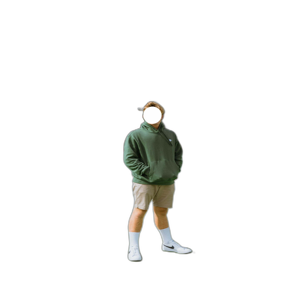

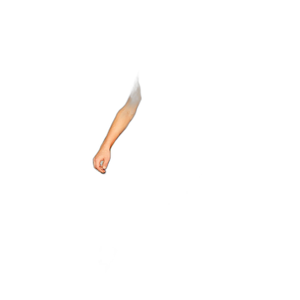

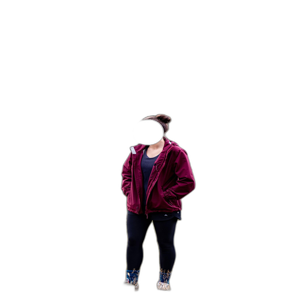

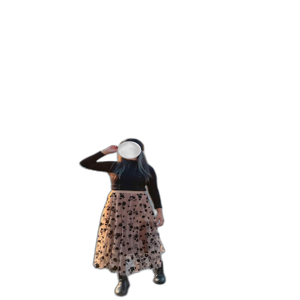

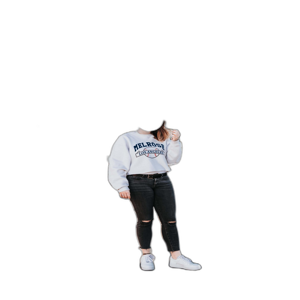

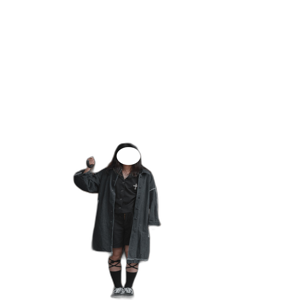

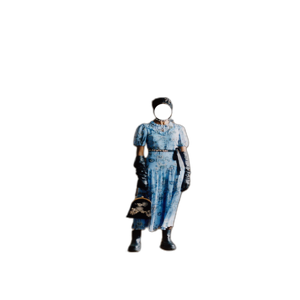

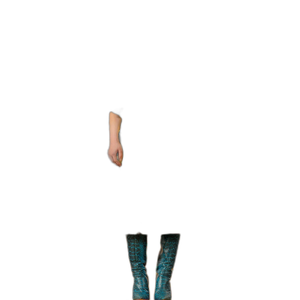

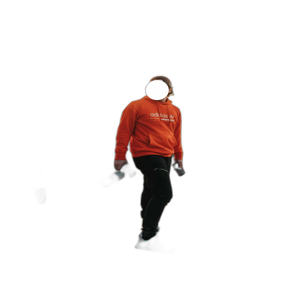

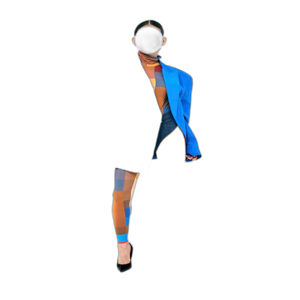

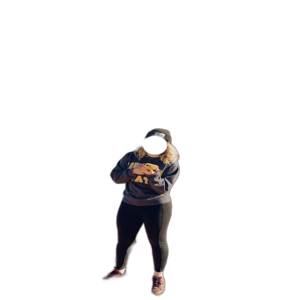

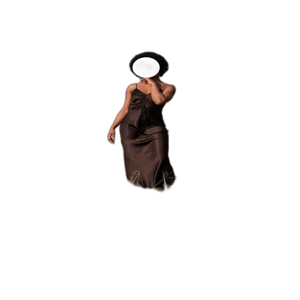

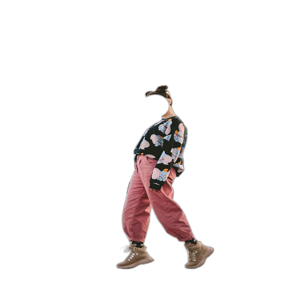

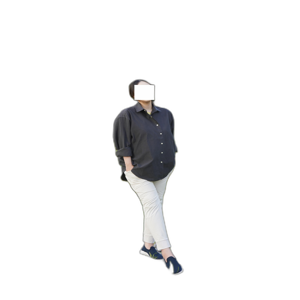

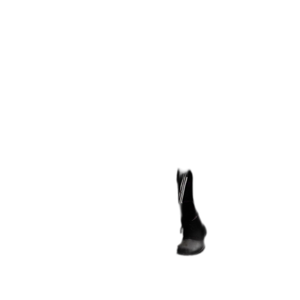

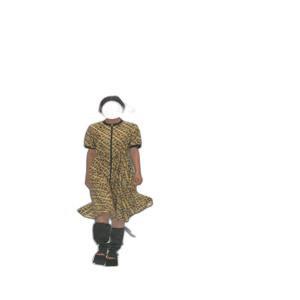

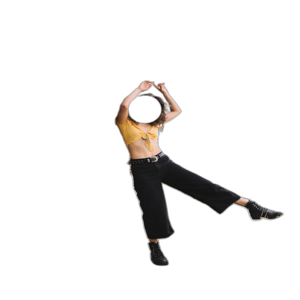

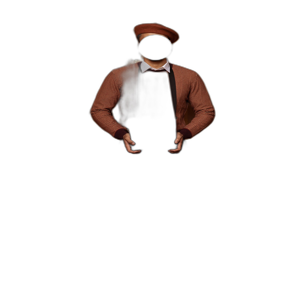

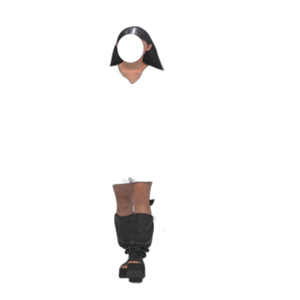

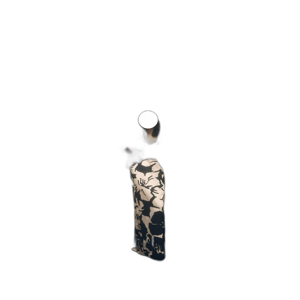

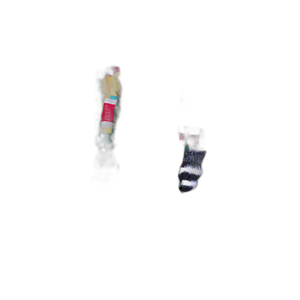

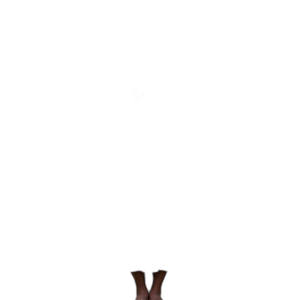

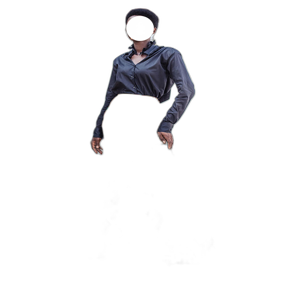

In [5]:
from IPython.display import display, Image
from PIL import Image as PILImage

# 이미지 표시
for path in anomalies:
    img = PILImage.open(path)  # 이미지 열기
    img = img.resize((300, 300))  # 이미지 리사이징 (300x300)
    display(img)  # 이미지 표시


### 배경 처리 고도화 모델 적용

분리가 제대로 안되는 그림들이 있는걸로 보아 U2net기반 모델의 한계가 있어 잘못 분리된 이미지에 대해 훨씬 좋은 성과를 보이고 있는 birefnet 구조의 모델을 사용해보았다.

birefnet은 2024년 DIS (Depth Image Segmentation): 깊이 정보를 사용하는 이미지 세분화 작업, COD (Camouflaged Object Detection): 위장된 객체를 탐지하는 작업, HRSOD (High-Resolution Salient Object Detection): 고해상도 이미지를 기반으로 주목할 만한 객체를 탐지하는 작업 에서 우수한 성과로 SOTA를 달성한 Image Segmentation모델이다.

다만, 좋은만큼 무거운 모델이라 1장 처리에 10초가 걸리고 CPU모델이 아닌 GPU모델이기에 병렬 계산을 하려면 여러 GPU가 있어야 한다.

In [55]:
import os
import io
from rembg import remove, new_session
from PIL import Image
def remove_background_single(image_path, output_dir, session):
    # 1. 이미지 가져오기
    with open(image_path, "rb") as img_file:
        input_img = img_file.read()
        
    # 2. 배경 제거
    out = remove(input_img, session=session)

    # 3. RGBA를 흰색 배경으로 변경
    out_img = Image.open(io.BytesIO(out))  # bytes 데이터를 PIL 이미지로 변환
    
    if out_img.mode == 'RGBA':
        # 흰색 배경을 가진 새로운 이미지 생성
        background = Image.new("RGB", out_img.size, (255, 255, 255))
        # 투명한 부분을 흰색으로 채움
        background.paste(out_img, (0, 0), out_img)
        out_img = background  # 흰색 배경을 가진 이미지로 대체
    
    # 4. 저장할 경로 지정
    img_name = os.path.basename(image_path)
    output_path = os.path.join(output_dir, img_name)

    # 5. 처리된 이미지 저장
    out_img.save(output_path, format='JPEG')  # JPEG로 저장

if __name__ == "__main__":
    # 단일 이미지 파일 경로와 출력 디렉토리 지정
    output_dir = './data/training_image_rembg_anormal'              # 저장할 디렉토리

    # 출력 디렉토리가 없다면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 배경 제거 및 처리된 이미지 저장
    model_name = "birefnet-portrait"
    session = new_session(model_name)
    anomal_train_path = [path.replace('training_image_rembg', 'training_image') for path in anomalies]
    for image_path in tqdm(anomal_train_path, leave=True, ncols=100):
        remove_background_single(image_path, output_dir, session=session)

100%|██████████| 23/23 [04:22<00:00, 11.41s/it]


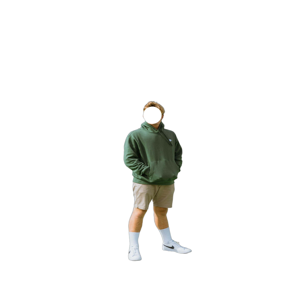

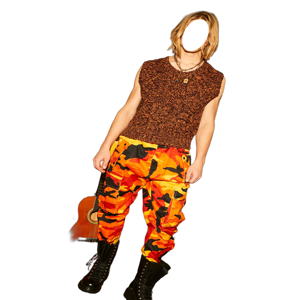

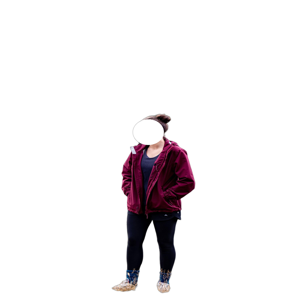

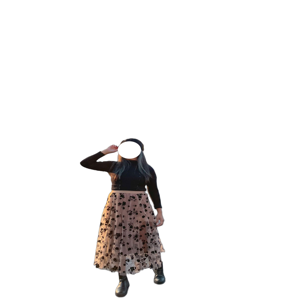

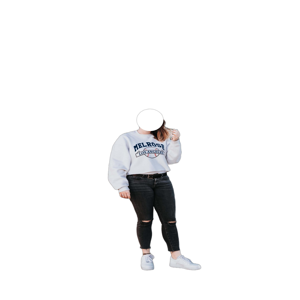

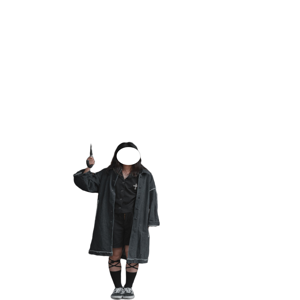

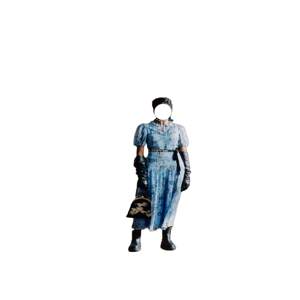

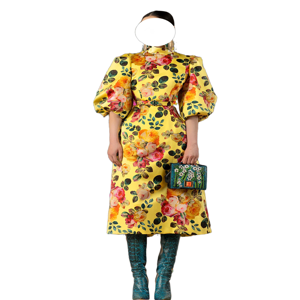

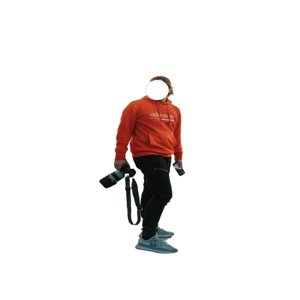

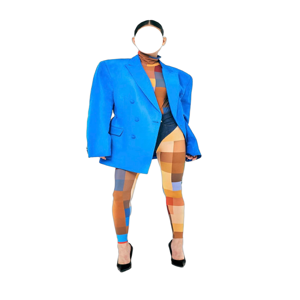

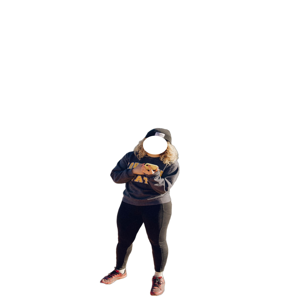

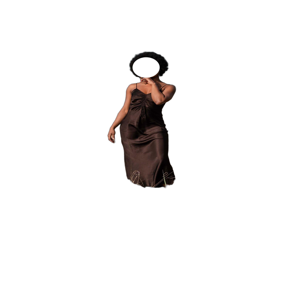

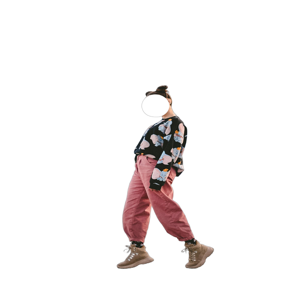

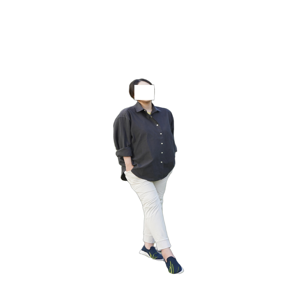

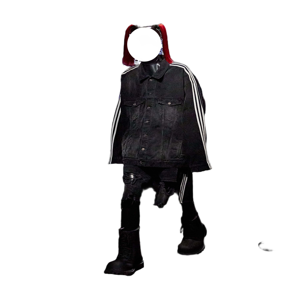

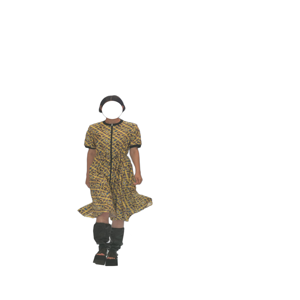

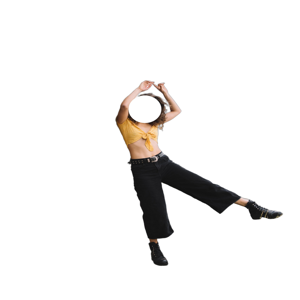

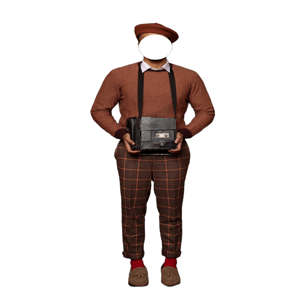

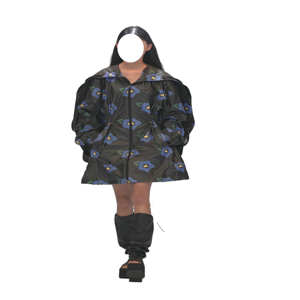

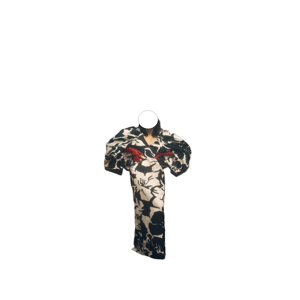

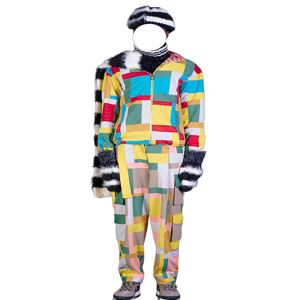

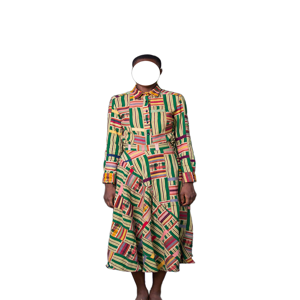

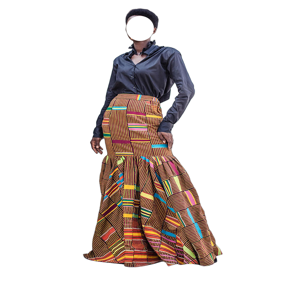

In [58]:
from IPython.display import display, Image
from PIL import Image as PILImage

# 이미지 표시
input_dir = './data/training_image_rembg_anormal'
image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
for path in image_paths:
    img = PILImage.open(path)  # 이미지 열기
    img = img.resize((300, 300))  # 이미지 리사이징 (300x300)
    display(img)  # 이미지 표시

Birefnet이 기존에 Segmentation이 어려웠던 이미지들을 모두 잘 분리한 것을 볼 수 있다.

위의 픽셀 검증 방법으로는 정상적으로 분리되었지만 흰색 픽셀이 많은 경우가 대부분이라 이상하게 처리된 이미지를 완전히 분리할 수 없어 

패션 데이터에서 배경 분리는 매우 중요한 요소이므로 오랜 시간이 걸리더라도 훈련셋 전체를 Birefnet으로 분리하기로 결정하였다. (14시간)

In [ ]:
import cv2
import numpy as np
import os
from PIL import Image
import torchvision.transforms.functional as F
from tqdm import tqdm
from multiprocessing import Pool

# 패딩을 통해 원본 패션 이미지의 비율을 지키는 이미지 리사이즈 클래스
class ResizeAndPad:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        w, h = img.size
        # 비율 유지하여 리사이즈
        new_h = self.target_size
        new_w = int(self.target_size * (w / h))
        
        img_resized = img.resize((new_w, new_h), Image.LANCZOS)
        
        # 패딩 추가
        if new_w < self.target_size:
            padding = (self.target_size - new_w) // 2
            img_padded = F.pad(img_resized, (padding, 0, padding, 0), fill=255)  # 흰색으로 패딩
        else:
            img_padded = img_resized

        return img_padded

def extract_bounding_box(image_path_and_params):
    image_path, output_dir, target_size = image_path_and_params

    # 이미지 불러오기
    img = cv2.imread(image_path)
    
    # 흰색 배경을 더 정확하게 인식하기 위해 inRange 사용
    lower_white = np.array([200, 200, 200], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)
    
    # 흰색 배경 제외한 마스크 생성
    mask = cv2.inRange(img, lower_white, upper_white)
    mask_inv = cv2.bitwise_not(mask)  # 흰색 배경 제외한 부분만 남김
    
    # 바운딩 박스 좌표 계산
    contours, _ = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        print(f"인물 영역을 찾지 못했습니다: {image_path}")
        return
    
    # 여러 개의 바운딩 박스를 처리하기 위해 모든 컨투어에서 가장 큰 사각형 찾기
    x_min, y_min, x_max, y_max = np.inf, np.inf, 0, 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)
    
    # 원본 이미지에서 해당 바운딩 박스 영역만 crop
    cropped_img = img[y_min:y_max, x_min:x_max]
    
    # OpenCV 이미지를 PIL 이미지로 변환
    pil_cropped_img = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    
    # 리사이즈 및 패딩 적용
    resizer = ResizeAndPad(target_size)
    final_img = resizer(pil_cropped_img)
    
    # 출력 디렉토리 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 잘라낸 이미지 저장 경로 설정
    img_name = os.path.basename(image_path).split('.')[0]
    output_path = os.path.join(output_dir, f"{img_name}.jpg")
    
    # 잘라낸 이미지 저장
    final_img.save(output_path)

if __name__ == "__main__":
    input_dir = './data/training_image_birefnet'  # 처리할 이미지가 있는 디렉토리
    output_dir = './data/training_image_cropped'  # 잘라낸 이미지 저장 디렉토리
    target_size = 224  # 원하는 크기 224x224)
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 입력 데이터 준비
    params = [(image_path, output_dir, target_size) for image_path in image_paths]
    
    # 모든 이미지에서 인물 부분만 잘라내기 및 리사이즈 (병렬 처리)
    with Pool() as pool:
        list(tqdm(pool.imap(extract_bounding_box, params), total=len(params)), ncols=100, leave=True)

위에서 했던 것과 마찬가지로, 데이터 정합성을 확인하고 결과를 검증해본다.

In [10]:
# 데이터 정합성 확인
training_image_list = get_file_list('data/training_image')
print(len(training_image_list))
rembg_image_list = get_file_list('data/training_image_birefnet')
print(len(training_image_list))

4070
4070


In [11]:
input_dir = './data/training_image'  # 처리할 원본 이미지가 있는 디렉토리
output_dir = './data/training_image_birefnet'   # 처리된 이미지 저장할 디렉토리

# output_dir에서 손상된 파일 리스트 찾기
corrupted_images = find_corrupted_images(output_dir)
print(f"손상된 파일 수: {len(corrupted_images)}")
# 손상된 파일 리스트를 기준으로 input_dir의 파일 경로 리스트 만들기
valid_image_paths = [os.path.join(input_dir, fname) for fname in corrupted_images if os.path.exists(os.path.join(input_dir, fname))]
# # 손상된 파일만 다시 처리
if valid_image_paths:
    process_images_in_parallel(valid_image_paths, output_dir, num_workers=4)


100%|████████████████████████████████████████████████████████| 4070/4070 [00:00<00:00, 23316.36it/s]

손상된 파일 수: 0


Calculating white pixel percentage: 100%|██████████████████████| 4070/4070 [00:40<00:00, 101.67it/s]


,image_path,white_pixel_ratio
0,./data/training_image_birefnet/W_01752_00_metr...,0.789301
1,./data/training_image_birefnet/W_46417_70_mili...,0.775396
2,./data/training_image_birefnet/W_01509_00_metr...,0.799774
3,./data/training_image_birefnet/W_18951_50_femi...,0.597848
4,./data/training_image_birefnet/W_29485_10_spor...,0.649896
...,...,...
4065,./data/training_image_birefnet/W_03060_50_femi...,0.723210
4066,./data/training_image_birefnet/W_00032_10_spor...,0.809295
4067,./data/training_image_birefnet/W_02918_10_spor...,0.810246
4068,./data/training_image_birefnet/W_08957_19_norm...,0.859291


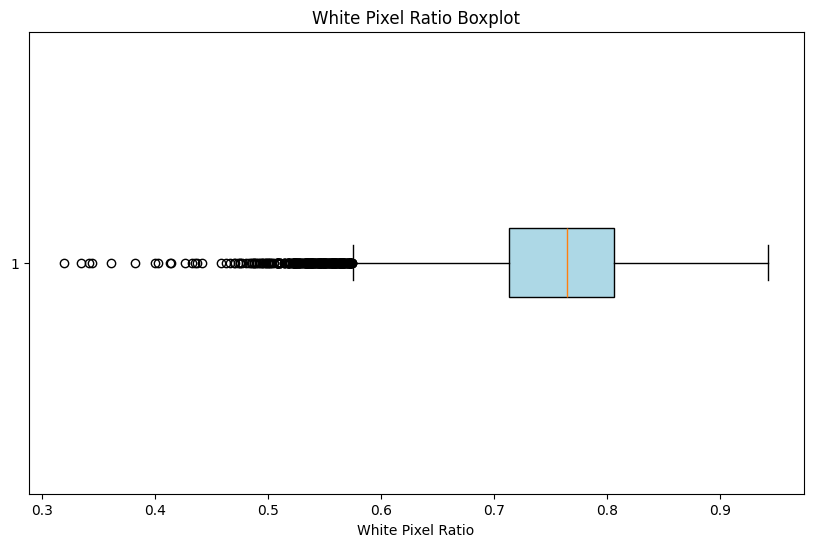

In [16]:
input_dir = './data/training_image_birefnet'  # 처리할 원본 이미지가 있는 디렉토리

# 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# 병렬로 흰색 픽셀 비율 계산 후 데이터프레임 생성
df = create_white_pixel_dataframe_parallel(image_paths, num_workers=50)

# 데이터프레임 저장 (필요한 경우)
display(df)

# boxplot 그리기
plot_white_pixel_boxplot(df)

In [21]:
# 90% 이상의 흰색 픽셀 비율을 가진 이미지 경로 찾기
anomal_train_path = df[df['white_pixel_ratio'] > 0.9]['image_path'].tolist()
anomal_train_path

['./data/training_image_birefnet/W_07271_10_sportivecasual_M.jpg',
 './data/training_image_birefnet/W_05502_00_ecology_W.jpg',
 './data/training_image_birefnet/W_01154_10_athleisure_W.jpg',
 './data/training_image_birefnet/W_07418_50_feminine_W.jpg',
 './data/training_image_birefnet/W_04377_10_sportivecasual_M.jpg',
 './data/training_image_birefnet/W_03849_10_athleisure_W.jpg',
 './data/training_image_birefnet/W_09008_10_sportivecasual_W.jpg',
 './data/training_image_birefnet/W_07785_70_hippie_W.jpg',
 './data/training_image_birefnet/W_09533_90_grunge_W.jpg',
 './data/training_image_birefnet/W_11726_50_feminine_W.jpg',
 './data/training_image_birefnet/W_08691_10_sportivecasual_W.jpg',
 './data/training_image_birefnet/W_07344_10_sportivecasual_M.jpg',
 './data/training_image_birefnet/W_02060_10_athleisure_W.jpg',
 './data/training_image_birefnet/W_02170_50_feminine_W.jpg',
 './data/training_image_birefnet/W_08040_90_kitsch_W.jpg',
 './data/training_image_birefnet/W_05513_60_minimal_W.jp

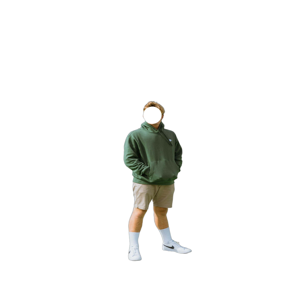

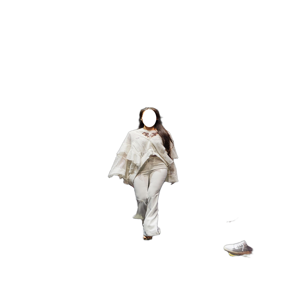

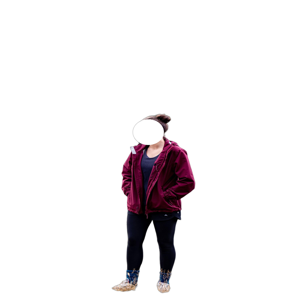

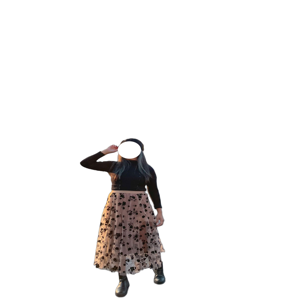

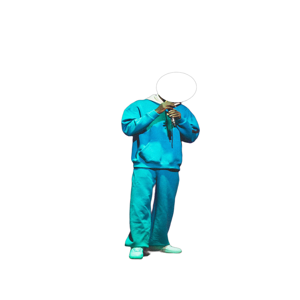

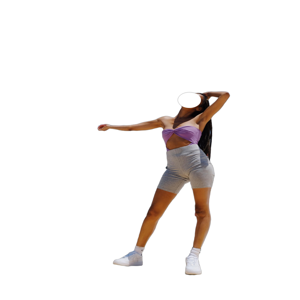

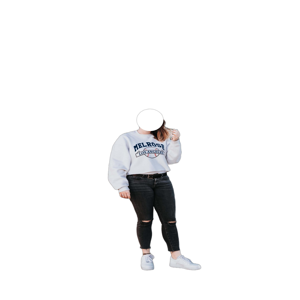

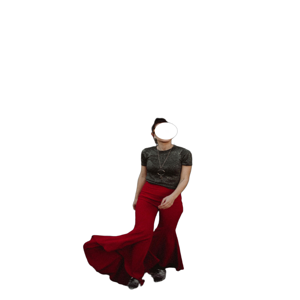

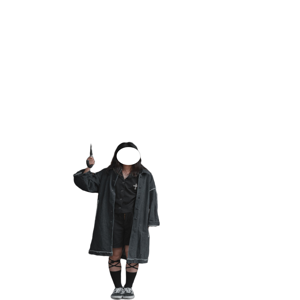

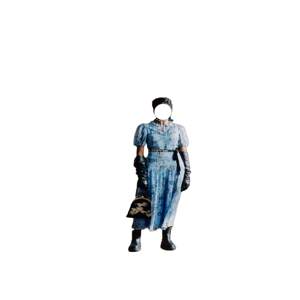

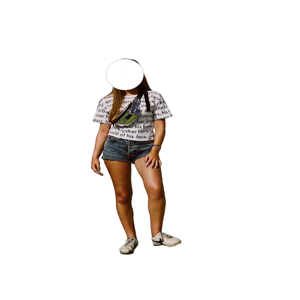

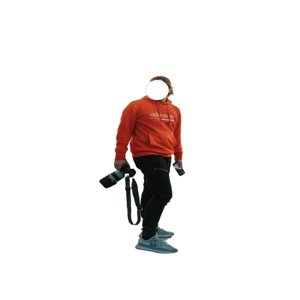

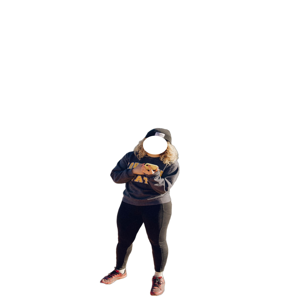

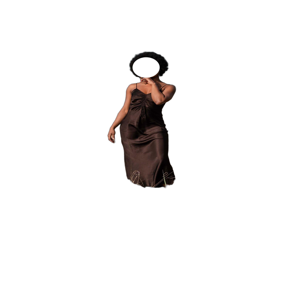

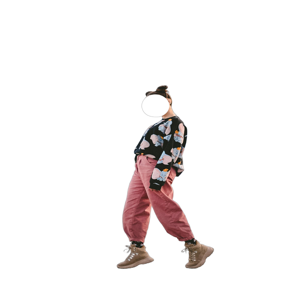

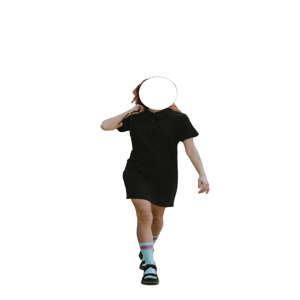

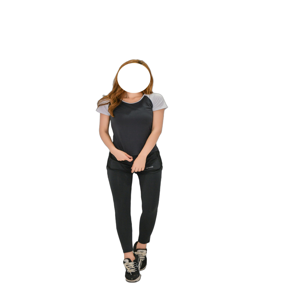

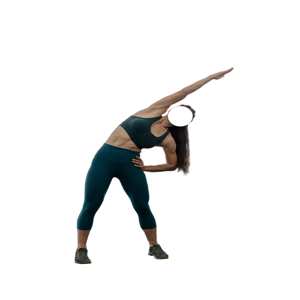

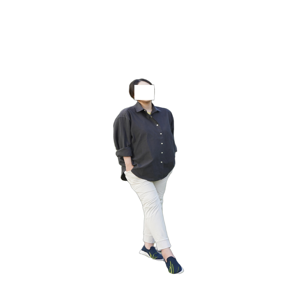

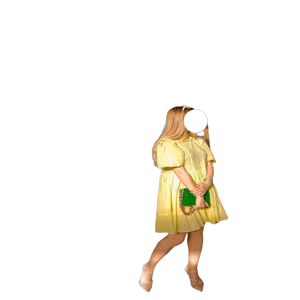

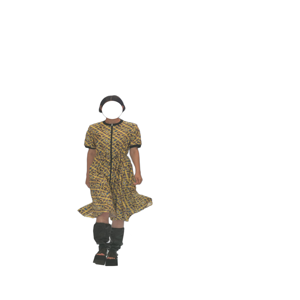

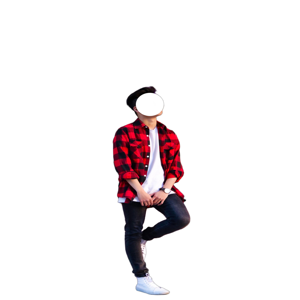

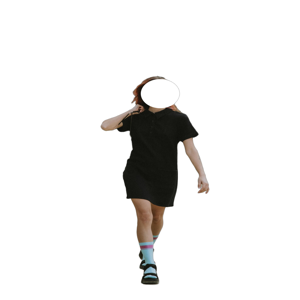

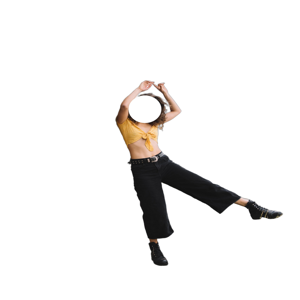

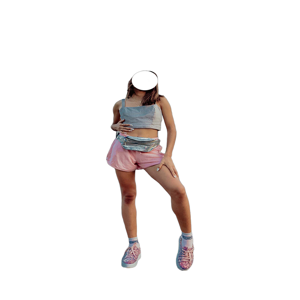

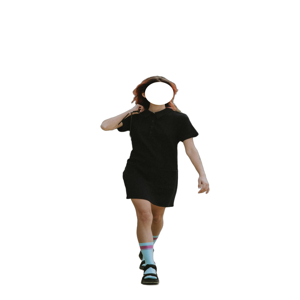

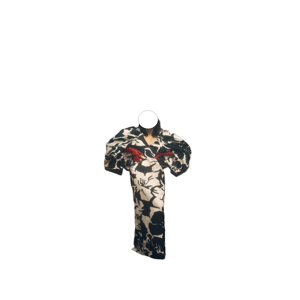

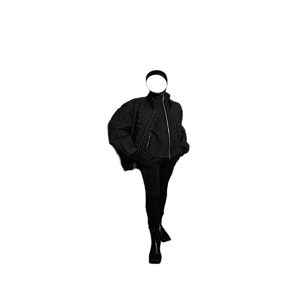

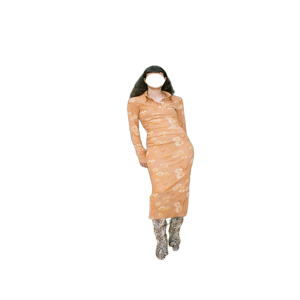

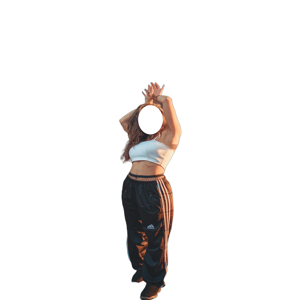

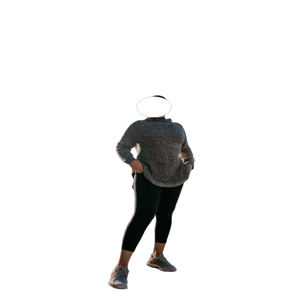

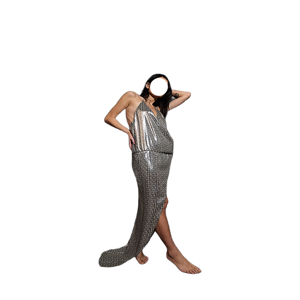

In [23]:
from IPython.display import display, Image
from PIL import Image as PILImage

# 이미지 표시
for path in anomal_train_path:
    img = PILImage.open(path)  # 이미지 열기
    img = img.resize((300, 300))  # 이미지 리사이징 (300x300)
    display(img)  # 이미지 표시

픽셀 검증 방식에서 90% 이상 흰색 배경이라도 모두 오류가 없는 데이터이다.

이전 U2net 대비 매우 깔끔하게 정리된 이미지들이라고 생각된다.

마지막으론, 패션이 존재하는 관심영역을 특정하기 위해 배경만 제거된 이미지에서 인물 영역을 찾아 흰색 배경을 제외한 부분만 잘라내어 저장한다.

이미지는 이미 배경이 제거되었으므로, CV의 윤곽선 검출을 통해 가장 큰 윤곽선을 감싸는 바운딩 박스를 검출하여 Crop한다.

그리고 이미지의 사이즈가 크므로, Resnet모델에 입력하기 위해 224x224로 사이즈로 리사이징 하는데, 패션이미지 특성상 비율을 맞춰서 패딩을 추가해 리사이징하여 저장한다.

In [23]:
import cv2
import numpy as np
import os
from PIL import Image
import torchvision.transforms.functional as F
from tqdm import tqdm
from multiprocessing import Pool

# 패딩을 통해 원본 패션 이미지의 비율을 지키는 이미지 리사이즈 클래스
class ResizeAndPad:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        w, h = img.size
        # 비율 유지하여 리사이즈
        new_h = self.target_size
        new_w = int(self.target_size * (w / h))
        
        img_resized = img.resize((new_w, new_h), Image.LANCZOS)
        
        # 패딩 추가
        if new_w < self.target_size:
            padding = (self.target_size - new_w) // 2
            img_padded = F.pad(img_resized, (padding, 0, padding, 0), fill=255)  # 흰색으로 패딩
        else:
            img_padded = img_resized

        return img_padded

def extract_bounding_box(image_path_and_params):
    image_path, output_dir, target_size = image_path_and_params

    # 이미지 불러오기
    img = cv2.imread(image_path)
    
    # 흰색 배경을 더 정확하게 인식하기 위해 inRange 사용
    lower_white = np.array([200, 200, 200], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)
    
    # 흰색 배경 제외한 마스크 생성
    mask = cv2.inRange(img, lower_white, upper_white)
    mask_inv = cv2.bitwise_not(mask)  # 흰색 배경 제외한 부분만 남김
    
    # 바운딩 박스 좌표 계산
    contours, _ = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        print(f"인물 영역을 찾지 못했습니다: {image_path}")
        return
    
    # 여러 개의 바운딩 박스를 처리하기 위해 모든 컨투어에서 가장 큰 사각형 찾기
    x_min, y_min, x_max, y_max = np.inf, np.inf, 0, 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)
    
    # 원본 이미지에서 해당 바운딩 박스 영역만 crop
    cropped_img = img[y_min:y_max, x_min:x_max]
    
    # OpenCV 이미지를 PIL 이미지로 변환
    pil_cropped_img = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    
    # 리사이즈 및 패딩 적용
    resizer = ResizeAndPad(target_size)
    final_img = resizer(pil_cropped_img)
    
    # 출력 디렉토리 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 잘라낸 이미지 저장 경로 설정
    img_name = os.path.basename(image_path).split('.')[0]
    output_path = os.path.join(output_dir, f"{img_name}.jpg")
    
    # 잘라낸 이미지 저장
    final_img.save(output_path)

if __name__ == "__main__":
    input_dir = './data/training_image_birefnet'  # 처리할 이미지가 있는 디렉토리
    output_dir = './data/training_image_cropped'  # 잘라낸 이미지 저장 디렉토리
    target_size = 224  # 원하는 크기 224x224)
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 입력 데이터 준비
    params = [(image_path, output_dir, target_size) for image_path in image_paths]
    
    # 모든 이미지에서 인물 부분만 잘라내기 및 리사이즈 (병렬 처리)
    with Pool(10) as pool:
        list(tqdm(pool.imap(extract_bounding_box, params), total=len(params), ncols=100, leave=True))


100%|██████████| 4070/4070 [01:30<00:00, 45.00it/s] 


최종 전처리된 이미지는 다음과 같다.

224x224로 비율을 지키며 모든 피사체가 중앙에 위치하도록 전처리되었다.

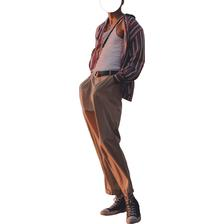

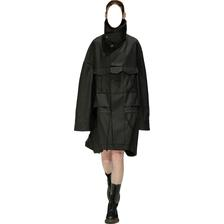

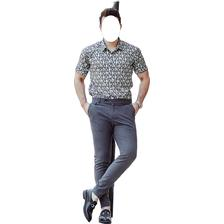

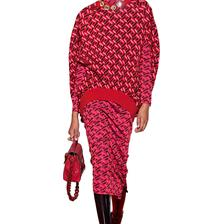

In [26]:
from IPython.display import display
from PIL import Image as PILImage

# 이미지 표시
input_dir = './data/training_image_cropped'
image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))][:4]
for path in image_paths:
    img = PILImage.open(path)  # 이미지 열기
    display(img)  # 이미지 표시

위 과정을 모두 Validation Image에도 적용해준다.

In [ ]:
import os
import io
import multiprocessing
from rembg import remove, new_session
from PIL import Image
from tqdm import tqdm  # tqdm 모듈 임포트

# 배경 제거 함수
def remove_background(args):
    image_path, output_dir = args  # unpacking 인자
    # 1. 이미지 가져오기
    with open(image_path, "rb") as img_file:
        input_img = img_file.read()
    
    # 2. 배경 제거
    model_name = "birefnet-portrait"
    session = new_session(model_name)

    out = remove(input_img, session=session)

    # 3. RGBA를 흰색 배경으로 변경
    out_img = Image.open(io.BytesIO(out))  # bytes 데이터를 PIL 이미지로 변환
    
    if out_img.mode == 'RGBA':
        # 흰색 배경을 가진 새로운 이미지 생성
        background = Image.new("RGB", out_img.size, (255, 255, 255))
        # 투명한 부분을 흰색으로 채움
        background.paste(out_img, (0, 0), out_img)
        out_img = background  # 흰색 배경을 가진 이미지로 대체
    
    # 4. 저장할 경로 지정
    img_name = os.path.basename(image_path)
    output_path = os.path.join(output_dir, img_name)

    # 5. 처리된 이미지 저장
    out_img.save(output_path, format='JPEG')  # JPEG로 저장

# 병렬 처리 함수
def process_images_in_parallel(image_paths, output_dir, num_workers=4):
    # 출력 디렉토리가 없다면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 멀티프로세싱 풀 생성
    pool = multiprocessing.Pool(num_workers)
    
    # tqdm을 사용하여 진행 상황 표시
    # 각 인자를 튜플로 전달
    for _ in tqdm(pool.imap(remove_background, [(image_path, output_dir) for image_path in image_paths]), total=len(image_paths), leave=True, ncols=100):
        pass
    
    # 풀 종료
    pool.close()
    pool.join()

if __name__ == "__main__":
    # 이미지 파일이 들어 있는 디렉토리와 출력 디렉토리 설정
    input_dir = './data/validation_image'  # 처리할 이미지가 있는 디렉토리
    output_dir = './data/validation_image_birefnet'   # 처리된 이미지 저장할 디렉토리
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 병렬로 이미지 처리
    process_images_in_parallel(image_paths, output_dir, num_workers=4)

In [4]:
input_dir = './data/validation_image'  # 처리할 원본 이미지가 있는 디렉토리
output_dir = './data/validation_image_birefnet'   # 처리된 이미지 저장할 디렉토리

# output_dir에서 손상된 파일 리스트 찾기
corrupted_images = find_corrupted_images(output_dir)
print(f"손상된 파일 수: {len(corrupted_images)}")
# 손상된 파일 리스트를 기준으로 input_dir의 파일 경로 리스트 만들기
valid_image_paths = [os.path.join(input_dir, fname) for fname in corrupted_images if os.path.exists(os.path.join(input_dir, fname))]
# # 손상된 파일만 다시 처리
if valid_image_paths:
    process_images_in_parallel(valid_image_paths, output_dir, num_workers=4)

100%|██████████████████████████████████████████████████████████| 951/951 [00:00<00:00, 24497.81it/s]

손상된 파일 수: 0


In [6]:
import cv2
import numpy as np
import os
from PIL import Image
import torchvision.transforms.functional as F
from tqdm import tqdm
from multiprocessing import Pool

# 패딩을 통해 원본 패션 이미지의 비율을 지키는 이미지 리사이즈 클래스
class ResizeAndPad:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        w, h = img.size
        # 비율 유지하여 리사이즈
        new_h = self.target_size
        new_w = int(self.target_size * (w / h))
        
        img_resized = img.resize((new_w, new_h), Image.LANCZOS)
        
        # 패딩 추가
        if new_w < self.target_size:
            padding = (self.target_size - new_w) // 2
            img_padded = F.pad(img_resized, (padding, 0, padding, 0), fill=255)  # 흰색으로 패딩
        else:
            img_padded = img_resized

        return img_padded

def extract_bounding_box(image_path_and_params):
    image_path, output_dir, target_size = image_path_and_params

    # 이미지 불러오기
    img = cv2.imread(image_path)
    
    # 흰색 배경을 더 정확하게 인식하기 위해 inRange 사용
    lower_white = np.array([200, 200, 200], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)
    
    # 흰색 배경 제외한 마스크 생성
    mask = cv2.inRange(img, lower_white, upper_white)
    mask_inv = cv2.bitwise_not(mask)  # 흰색 배경 제외한 부분만 남김
    
    # 바운딩 박스 좌표 계산
    contours, _ = cv2.findContours(mask_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        print(f"인물 영역을 찾지 못했습니다: {image_path}")
        return
    
    # 여러 개의 바운딩 박스를 처리하기 위해 모든 컨투어에서 가장 큰 사각형 찾기
    x_min, y_min, x_max, y_max = np.inf, np.inf, 0, 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x + w)
        y_max = max(y_max, y + h)
    
    # 원본 이미지에서 해당 바운딩 박스 영역만 crop
    cropped_img = img[y_min:y_max, x_min:x_max]
    
    # OpenCV 이미지를 PIL 이미지로 변환
    pil_cropped_img = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    
    # 리사이즈 및 패딩 적용
    resizer = ResizeAndPad(target_size)
    final_img = resizer(pil_cropped_img)
    
    # 출력 디렉토리 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 잘라낸 이미지 저장 경로 설정
    img_name = os.path.basename(image_path).split('.')[0]
    output_path = os.path.join(output_dir, f"{img_name}.jpg")
    
    # 잘라낸 이미지 저장
    final_img.save(output_path)

if __name__ == "__main__":
    input_dir = './data/validation_image_birefnet'  # 처리할 이미지가 있는 디렉토리
    output_dir = './data/validation_image_cropped'  # 잘라낸 이미지 저장 디렉토리
    target_size = 224  # 원하는 크기 224x224)
    
    # 입력 디렉토리 내 모든 이미지 파일 경로 리스트 만들기
    image_paths = [os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(('.png', '.jpg', '.jpeg'))]
    
    # 입력 데이터 준비
    params = [(image_path, output_dir, target_size) for image_path in image_paths]
    
    # 모든 이미지에서 인물 부분만 잘라내기 및 리사이즈 (병렬 처리)
    with Pool(10) as pool:
        list(tqdm(pool.imap(extract_bounding_box, params), total=len(params), ncols=100, leave=True))

100%|█████████████████████████████████████████████████████████████| 951/951 [00:10<00:00, 88.24it/s]


Validation Set이므로 일반화 성능 검증을 위해 따로 결과에 대해 전처리가 잘 됬는가는 검증하지 않는다.

이제 전처리된 training_image_cropped, validation_image_cropped 이미지들을 Pytorch기반 모델에 로드하고

학습을 위한 데이터셋을 설계한다.

In [1]:
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

#이미지 이름으로 분류된 폴더에서 이미지를 불러오는 데이터셋 클래스
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = self.get_image_labels()

    def get_image_labels(self):
        img_labels = []
        for img_file in os.listdir(self.img_dir):
            label = self.extract_label_from_filename(img_file)
            img_labels.append((img_file, label))
        return img_labels

    def extract_label_from_filename(self, filename):
        label = "_".join(filename.split(".")[0].split("_")[3:]) # Extract label from filename
        return label

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name, label = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터셋과 데이터로더 생성
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = CustomImageDataset(img_dir='./data/training_image_cropped', transform=transform)

클래스의 분포를 확인한다.

In [2]:
from collections import Counter

class_counts = Counter([label for _, label in dataset.img_labels])  # 수정된 부분
total_samples = sum(class_counts.values())
print(f"클래스별 샘플 수: {class_counts}")
print(f"전체 샘플 수: {total_samples}")

# 각 클래스의 비율 계산
class_ratios = {cls: count / total_samples*100 for cls, count in class_counts.items()}

# 소수 클래스 식별 (정렬 후 하위 5개 클래스)
minority_classes = dict(sorted(class_ratios.items(), key=lambda x: x[1]))

display(minority_classes)

클래스별 샘플 수: Counter({'normcore_M': 364, 'sportivecasual_M': 298, 'metrosexual_M': 278, 'hiphop_M': 274, 'mods_M': 269, 'bold_M': 268, 'hippie_M': 260, 'ivy_M': 237, 'sportivecasual_W': 157, 'feminine_W': 154, 'normcore_W': 153, 'minimal_W': 139, 'powersuit_W': 120, 'bodyconscious_W': 95, 'kitsch_W': 91, 'hippie_W': 91, 'oriental_W': 78, 'classic_W': 77, 'genderless_W': 77, 'athleisure_W': 67, 'cityglam_W': 67, 'punk_W': 65, 'ecology_W': 64, 'lingerie_W': 55, 'hiphop_W': 48, 'lounge_W': 45, 'popart_W': 41, 'space_W': 37, 'disco_W': 37, 'military_W': 33, 'grunge_W': 31})
전체 샘플 수: 4070


{'grunge_W': 0.7616707616707616,
 'military_W': 0.8108108108108109,
 'space_W': 0.9090909090909091,
 'disco_W': 0.9090909090909091,
 'popart_W': 1.0073710073710074,
 'lounge_W': 1.1056511056511056,
 'hiphop_W': 1.1793611793611793,
 'lingerie_W': 1.3513513513513513,
 'ecology_W': 1.5724815724815724,
 'punk_W': 1.597051597051597,
 'athleisure_W': 1.6461916461916464,
 'cityglam_W': 1.6461916461916464,
 'classic_W': 1.891891891891892,
 'genderless_W': 1.891891891891892,
 'oriental_W': 1.9164619164619165,
 'kitsch_W': 2.235872235872236,
 'hippie_W': 2.235872235872236,
 'bodyconscious_W': 2.334152334152334,
 'powersuit_W': 2.9484029484029484,
 'minimal_W': 3.4152334152334154,
 'normcore_W': 3.7592137592137593,
 'feminine_W': 3.783783783783784,
 'sportivecasual_W': 3.857493857493857,
 'ivy_M': 5.823095823095823,
 'hippie_M': 6.388206388206388,
 'bold_M': 6.5847665847665855,
 'mods_M': 6.6093366093366095,
 'hiphop_M': 6.732186732186732,
 'metrosexual_M': 6.830466830466831,
 'sportivecasual_M':

전체 분포가 1%~7% 대로 분포해있으므로, 각 분포별로 증강을 적용해서 클래스 균형을 맞춰준다. 

기본적인 이미지가 약 4000개므로, 클래스당 최소 1000장 정도가 맞춰지도록 5배 증강을 기본으로, 10배, 20배 증강을 적용하였다.

In [3]:
# 소수 클래스 및 비율 정의
minority_classes_1 = [cls for cls, ratio in minority_classes.items() if ratio <= 2]  # 2% 이하
minority_classes_2 = [cls for cls, ratio in minority_classes.items() if 2 < ratio <= 4]  # 4% 이하
middle_classes = [cls for cls, ratio in minority_classes.items() if ratio > 4]  # 6% 초과

import os
from PIL import Image
from tqdm import tqdm
from multiprocessing import Pool
from torchvision import transforms

# 각 클래스에 따른 증강 전략 설정
def augment_image(args):
    img_file, label, extra_transforms = args
    img_path = os.path.join(dataset.img_dir, img_file)
    image = Image.open(img_path).convert("RGB")
    
    augmented_data = []

    if label in minority_classes_1:
        # 1% 클래스에 대해 많이 증강
        for _ in range(20):  # 20배 증강
            augmented_img = extra_transforms(image)
            augmented_data.append((augmented_img, label))
    elif label in minority_classes_2:
        # 2% 클래스에 대해 보통 증강
        for _ in range(10):  # 10배 증강
            augmented_img = extra_transforms(image)
            augmented_data.append((augmented_img, label))
    else:
        # 일반 클래스에 대해 약간의 증강
        for _ in range(5):  # 5배 증강
            augmented_img = extra_transforms(image)
            augmented_data.append((augmented_img, label))

    return augmented_data

# 소수 클래스에 대해 적용할 추가 증강
additional_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 랜덤 수평 뒤집기
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),  # 색상 조정
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # 랜덤 원근 변환
    transforms.RandomAffine(degrees=(-20, 20), shear=10),  # 랜덤 각도, 기울기 변환
    transforms.ToTensor()
])

def save_augmented_images(augmented_data, output_dir):
    # 출력 디렉토리 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, (img_tensor, label) in enumerate(augmented_data):
        # 텐서를 PIL 이미지로 변환
        img = transforms.ToPILImage()(img_tensor)
        # 저장할 파일 이름 설정
        img_filename = f"PRE_PROCESS_{i}_{label}.jpg"
        img_path = os.path.join(output_dir, img_filename)
        img.save(img_path)


# 병렬 처리 설정
if __name__ == '__main__':
    dataset_args = [(img_file, label, additional_transforms) for img_file, label in dataset.img_labels]

    augmented_data = []
    with Pool(processes=50) as pool:
        for result in tqdm(pool.imap(augment_image, dataset_args), total=len(dataset_args), desc="Augmenting Images", ncols=100, leave=True):
            augmented_data.extend(result)
    
    output_dir = './data/training_image_augmented'
    save_augmented_images(augmented_data, output_dir)

Augmenting Images: 100%|████████████████████████████████████████| 4070/4070 [33:32<00:00,  2.02it/s]


증강한 데이터를 불러와서 제대로 적용되었는지 살펴보았다.

In [1]:
import os
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

#이미지 이름으로 분류된 폴더에서 이미지를 불러오는 훈련용 데이터셋 클래스
class TrainingImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, label_encoder=None, is_training=False):
        self.img_dir = img_dir
        self.transform = transform
        self.img_labels = self.get_image_labels()
        self.is_training = is_training
        
        if self.is_training:
            # 훈련 데이터에서는 LabelEncoder 사용
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform([label for _, label in self.img_labels])
        else:
            # 평가/테스트 모드에서는 인코딩 없이 원래 레이블을 유지
            self.labels = [label for _, label in self.img_labels]

    def get_image_labels(self):
        img_labels = []
        for img_file in os.listdir(self.img_dir):
            label = self.extract_label_from_filename(img_file)
            img_labels.append((img_file, label))
        return img_labels

    def extract_label_from_filename(self, filename):
        label = "_".join(filename.split(".")[0].split("_")[3:]) # Extract label from filename
        return label

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        if self.is_training:
            img_name = self.img_labels[idx][0]
            label = self.labels[idx]
        else:
            img_name, label = self.img_labels[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터셋과 데이터로더 생성
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = TrainingImageDataset(img_dir='./data/training_image_cropped', transform=transform)
dataset_augmented = TrainingImageDataset(img_dir='./data/training_image_augmented', transform=transform)

# 두 데이터셋을 합치기
from torch.utils.data import ConcatDataset

class CustomConcatDataset(ConcatDataset):
    def __init__(self, datasets):
        super().__init__(datasets)
        self.labels = []
        for dataset in datasets:
            self.labels.extend(dataset.labels)

concat_dataset = CustomConcatDataset([dataset, dataset_augmented])


증강이 잘 적용된것을 볼 수 있다.

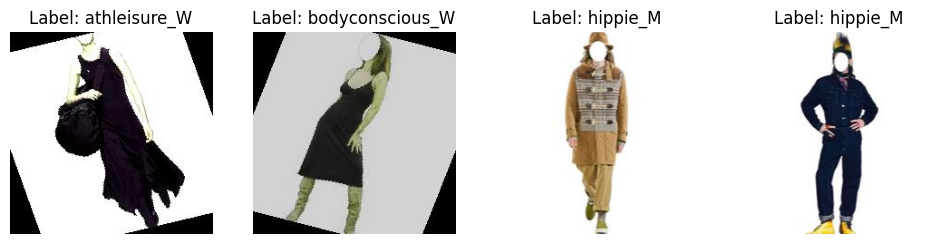

In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# DataLoader를 사용하여 배치로 데이터 가져오기
data_loader = DataLoader(concat_dataset, batch_size=4, shuffle=True)

# 배치에서 이미지와 레이블 가져오기
images, labels = next(iter(data_loader))

# 이미지 시각화
def show_images(images, labels):
    # 이미지 수에 따라 서브플롯 크기 설정
    fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

show_images(images, labels)


증강 수치는 4070 -> 41750 로 전체적으론 10배 가량 증폭되었다.

소수 클래스에 대해 많이 증강했음에도, 일반적인 데이터에도 증강을 적용하니 3배정도의 차이가 있다.

소량의 데이터로 증강을 많이 하면 과적합 우려가 있어 데이터 로더에 WeightedRandomSampler를 적용하여 

소수 클래스가 균형적으로 학습될 수 있도록 데이터 샘플링 확률을 조정한다.

In [2]:
from collections import Counter

# 클래스 카운트
class_counts = Counter([label for label in dataset.labels])
# class_counts = Counter([label for label in concat_dataset.labels])
total_samples = sum(class_counts.values())

# 결과 정렬
sorted_class_counts = class_counts.most_common()
num_classes = len(class_counts)
# 결과 출력
print(f"전체 샘플 수: {total_samples}")
print(f"클래스 개수: {num_classes}")
print(f"클래스별 샘플 수:{sorted_class_counts}")


전체 샘플 수: 4070
클래스 개수: 31
클래스별 샘플 수:[('normcore_M', 364), ('sportivecasual_M', 298), ('metrosexual_M', 278), ('hiphop_M', 274), ('mods_M', 269), ('bold_M', 268), ('hippie_M', 260), ('ivy_M', 237), ('sportivecasual_W', 157), ('feminine_W', 154), ('normcore_W', 153), ('minimal_W', 139), ('powersuit_W', 120), ('bodyconscious_W', 95), ('kitsch_W', 91), ('hippie_W', 91), ('oriental_W', 78), ('classic_W', 77), ('genderless_W', 77), ('athleisure_W', 67), ('cityglam_W', 67), ('punk_W', 65), ('ecology_W', 64), ('lingerie_W', 55), ('hiphop_W', 48), ('lounge_W', 45), ('popart_W', 41), ('space_W', 37), ('disco_W', 37), ('military_W', 33), ('grunge_W', 31)]


다음은 훈련용 데이터셋 준비이다.

각 샘플 수를 1로 나눠 취한 역수로 구한 가중치를 데이터 로더에 주어 더 적은 샘플로 이루어진 데이터가 학습 시, 더 많이 노출되도록 한다.

또한 학습을 위해 클래스 정보를 라벨인코딩하여 숫자로 바꿔 모델이 예측할 수 있게한다.

In [3]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder

weights = {cls: 1.0 / count for cls, count in class_counts.items()}
# sample_weights = [weights[label] for label in concat_dataset.labels]
sample_weights = [weights[label] for label in dataset.labels]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit([label for label in concat_dataset.labels])

train_dataset = TrainingImageDataset(img_dir='./data/training_image_cropped', transform=transform, label_encoder=label_encoder, is_training=True)
# dataset_augmented = TrainingImageDataset(img_dir='./data/training_image_augmented', transform=transform, label_encoder=label_encoder, is_training=True)

# train_dataset = CustomConcatDataset([dataset, dataset_augmented])

train_loader = DataLoader(train_dataset, batch_size=256, sampler=sampler, num_workers=8)

val_dataset = TrainingImageDataset(img_dir='./data/validation_image_cropped', transform=transform, label_encoder=label_encoder, is_training=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers=4)



In [4]:
print("훈련 이미지 갯수 : ", len(train_dataset))
print("검증 이미지 갯수 : ", len(val_dataset))
print("클래스 갯수 : ", len(label_encoder.classes_))

훈련 이미지 갯수 :  4070
검증 이미지 갯수 :  951
클래스 갯수 :  31


다음은 모델 구현이다. Pytorch에 구현되어 있는 기본 resnet18구조를 불러왔고, 사전 가중치는 미션 제약에 따라 불러오지 않는다.

또한 배치마다 이미지의 평균과, 표준편차를 구해 정규화를 적용한다.

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
import time

# ResNet18 모델 초기화 (사전 가중치 사용 안 함)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(label_encoder.classes_))  # 마지막 레이어 변경

num_total_params = sum(p.numel() for p in model.parameters())
print("총 파라미터 갯수 : ", num_total_params)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
gpu_name = torch.cuda.get_device_name(device)
print(f"사용 중인 GPU: {gpu_name}")

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def normalize_batch(batch):
    mean = batch.mean([0, 2, 3], keepdim=True)  # 채널별 평균 계산
    std = batch.std([0, 2, 3], keepdim=True)    # 채널별 표준편차 계산
    return (batch - mean) / std

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = torch.sum(preds == labels).item()
    return correct / len(preds) * 100

# 모델 훈련 함수
def train_model(model, criterion, optimizer, num_epochs=150):
    print("Training started...")
    start = time.time()
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    model.train()
    
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_train_acc = 0.0
        running_test_loss = 0.0
        running_test_acc = 0.0
        for images, labels in train_loader:
            images = normalize_batch(images).to(device)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            running_train_acc += accuracy(outputs, labels)
        train_loss.append(running_train_loss / len(train_loader))
        train_acc.append(running_train_acc / len(train_loader))
        
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()
                running_test_acc += accuracy(outputs, labels)
            test_loss.append(running_test_loss / len(val_loader))
            test_acc.append(running_test_acc / len(val_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, Test Loss: {test_loss[-1]:.4f}, Test Acc: {test_acc[-1]:.2f}%")
        
    end = time.time()
    minute = (end-start)//60
    print(f"Training time: {minute}m {end-start-minute*60:.2f}s")
    return train_loss, train_acc, test_loss, test_acc, model

train_loss, train_acc, test_loss, test_acc, model = train_model(model, criterion, optimizer, num_epochs=50)

총 파라미터 갯수 :  11192415
사용 중인 GPU: NVIDIA RTX A5000
Training started...
Epoch 1/150, Train Loss: 3.3276, Train Acc: 9.29%, Test Loss: 4.5368, Test Acc: 3.55%
Epoch 2/150, Train Loss: 4.0183, Train Acc: 3.10%, Test Loss: 3.4869, Test Acc: 2.31%
Epoch 3/150, Train Loss: 3.4446, Train Acc: 3.40%, Test Loss: 3.4350, Test Acc: 1.40%
Epoch 4/150, Train Loss: 3.4321, Train Acc: 3.90%, Test Loss: 3.4110, Test Acc: 4.62%
Epoch 5/150, Train Loss: 3.4172, Train Acc: 4.31%, Test Loss: 3.4088, Test Acc: 2.99%
Epoch 6/150, Train Loss: 3.3944, Train Acc: 4.14%, Test Loss: 3.4032, Test Acc: 4.75%
Epoch 7/150, Train Loss: 3.3935, Train Acc: 5.09%, Test Loss: 3.3812, Test Acc: 7.49%
Epoch 8/150, Train Loss: 3.3973, Train Acc: 5.49%, Test Loss: 3.3772, Test Acc: 6.64%
Epoch 9/150, Train Loss: 3.4000, Train Acc: 5.42%, Test Loss: 3.3852, Test Acc: 4.30%
Epoch 10/150, Train Loss: 3.3911, Train Acc: 5.69%, Test Loss: 3.3679, Test Acc: 7.39%
Epoch 11/150, Train Loss: 3.3866, Train Acc: 5.46%, Test Loss: 3.3668

KeyboardInterrupt: 